In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import PTA

from IPython.display import display

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="ipyrad")
print(len(ipyclient))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
40


## Generate simulations for proportional msfs

In [5]:
# sorted
model = PTA.DemographicModel("expanding-sorted-props")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 14)
model.set_param("nsamps", 8)
model.set_param("N_e", "2e5-5e6")
model.set_param("tau", "1e4-1e6")
model.set_param("epsilon", "0.01-0.1")
model.set_param("length", "150")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 500)
model.set_param("recoms_per_gen", 0)
model.set_param("muts_per_gen", 6.6e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = True
model._hackersonly["proportional_msfs"] = True
model.simulate(nsims=40000, quiet=False, verbose=False, ipyclient=ipyclient)

------- PTA params file (v.0.0.11)----------------------------------------------
expanding-sorted-props ## [0] [simulation_name]: The name of this simulation scenario
/media/4TB/isaac/PTA-EasternSnakes/analysis/simulations ## [1] [project_dir]: Where to save files
14                   ## [2] [npops]: Number of populations undergoing co-demographic processes
8                    ## [3] [nsamps]: Numbers of samples for each populations
200000-5000000       ## [4] [N_e]: Effective population size of the contemporary population
10000-1000000        ## [5] [tau]: Time of demographic change
0.01-0.1             ## [6] [epsilon]: Magnitude of demographic change
0                    ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
150                  ## [8] [length]: Length in bp of each independent genomic region to simulate
500,500,500,500,500,500,500,500,500,500,500,500,500,500 ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ##

In [ ]:
# unsorted
model = PTA.DemographicModel("expanding-unsorted-props")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 14)
model.set_param("nsamps", 8)
model.set_param("N_e", "2e5-5e6")
model.set_param("tau", "1e4-1e6")
model.set_param("epsilon", "0.01-0.1")
model.set_param("length", "150")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 500)
model.set_param("recoms_per_gen", 0)
model.set_param("muts_per_gen", 6.6e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = False
model._hackersonly["proportional_msfs"] = True
model.simulate(nsims=40000, quiet=False, verbose=False, ipyclient=ipyclient)

## Classification cross-validation
40k sims ~ 1hr

In [ ]:
# The 'reference table'
sorted_sim_df = pd.read_csv("analysis/simulations/expanding-sorted-props-SIMOUT.csv", sep=" ")
print(len(sorted_sim_df))
# This is a input
synthetic_community = pd.DataFrame(sorted_sim_df.loc[0]).T.drop(PTA.inference.default_targets, axis=1)

# GB parameters from experimentation which are known to work well
gb_params = {'n_estimators': 250,
             'min_samples_split': 5,
             'min_samples_leaf': 4,
             'max_features': 'auto',
             'max_depth': 10,
             'learning_rate': 0.012589254117941661}

gb_sorted_cl = PTA.inference.Classifier(empirical_df=synthetic_community,
                                       sims=sorted_sim_df,
                                       algorithm="gb")
# Set GB model params
gb_sorted_cl.set_params(gb_params)
# Set the target for classification
gb_sorted_cl.set_targets(["zeta_e"])
# Run quickly to set up the model
gb_sorted_cl.predict(select_features=False, param_search=False, quick=True, verbose=True)
# Do the cross validation prediction
cv_preds = gb_sorted_cl.cross_val_predict(cv=3,
                    quick=True,
                    verbose=True)

280040
Predict() started: 2023-05-12 10:49:32.873637


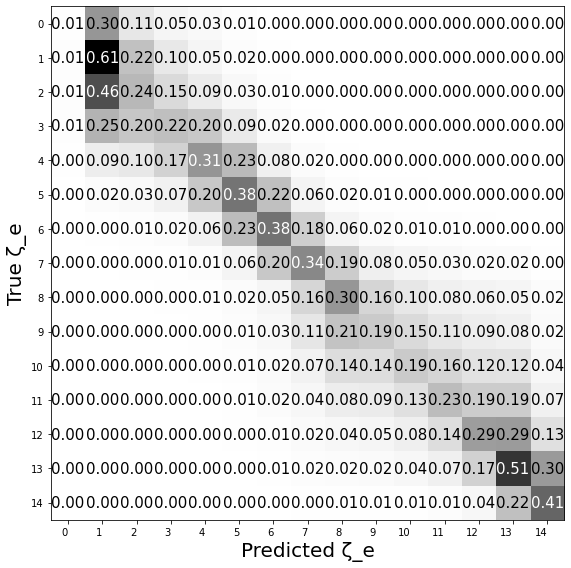

In [39]:
ax = gb_sorted_cl.plot_confusion_matrix(normalize=True)

## Predict zeta from empirical data

In [40]:
%%time
# Load msfs and reshape it into a format the ML stuff expects
sorted_expanding_msfs = pd.read_csv("analysis/msfs/proj8-sort-props.msfs", index_col=0)
sorted_expanding_msfs = pd.DataFrame(sorted_expanding_msfs.to_numpy().ravel(order="F"), index=synthetic_community.columns).T
display(sorted_expanding_msfs)

gb_sorted_cl.set_data(sorted_expanding_msfs)
gb_class_est = gb_sorted_cl.predict(select_features=False,\
                                    param_search=False,\
                                    quick=True,\
                                    verbose=True)
#axs = gb_sorted_cl.plot_feature_importance()
gb_class_est

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]],pop6-[[7_1]],pop6-[[6_2]],pop6-[[5_3]],pop6-[[4_4]],pop7-[[7_1]],pop7-[[6_2]],pop7-[[5_3]],pop7-[[4_4]],pop8-[[7_1]],pop8-[[6_2]],pop8-[[5_3]],pop8-[[4_4]],pop9-[[7_1]],pop9-[[6_2]],pop9-[[5_3]],pop9-[[4_4]],pop10-[[7_1]],pop10-[[6_2]],pop10-[[5_3]],pop10-[[4_4]],pop11-[[7_1]],pop11-[[6_2]],pop11-[[5_3]],pop11-[[4_4]],pop12-[[7_1]],pop12-[[6_2]],pop12-[[5_3]],pop12-[[4_4]],pop13-[[7_1]],pop13-[[6_2]],pop13-[[5_3]],pop13-[[4_4]]
0,0.733887,0.239843,0.174959,0.080827,0.712452,0.230946,0.173487,0.078543,0.706672,0.226319,0.152894,0.068655,0.706339,0.223852,0.147902,0.063709,0.675971,0.211012,0.133761,0.057377,0.673302,0.184814,0.119381,0.055943,0.663604,0.181769,0.109614,0.051165,0.654406,0.172104,0.107888,0.050682,0.652572,0.171509,0.106567,0.048601,0.59785,0.171188,0.106027,0.047301,0.56207,0.166222,0.105484,0.04691,0.554598,0.159658,0.096186,0.046273,0.513267,0.131381,0.093394,0.040277,0.508127,0.123018,0.089673,0.037766


Predict() started: 2023-05-13 16:55:21.626310
CPU times: user 88.9 ms, sys: 8.01 ms, total: 96.9 ms
Wall time: 94.5 ms


(          zeta_e
 estimate       3,
              0         1         2         3         4        5         6   \
 zeta_e  0.01506  0.034262  0.123167  0.304402  0.047666  0.20447  0.058016   
 
               7         8         9         10        11        12      13  \
 zeta_e  0.057296  0.053919  0.036676  0.017543  0.022481  0.012349  0.0088   
 
               14  
 zeta_e  0.003896  )

<BarContainer object of 15 artists>

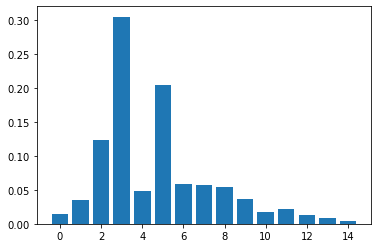

In [41]:
plt.bar(np.arange(15), gb_class_est[1].values[0])

## Hackish posterior predictive check

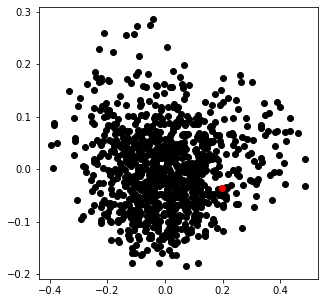

In [42]:
from sklearn.decomposition import PCA

estimated_zeta = 3

dat = sorted_sim_df[sorted_sim_df["zeta_e"] == estimated_zeta].iloc[:1000, 23:]
dat = pd.concat([sorted_expanding_msfs, dat])

pca = PCA(n_components=2)
pcs = pca.fit_transform(dat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pcs[:, 0], pcs[:, 1], c='black')
## Plot the observed ss in red
ax.scatter(pcs[:, 0][0], pcs[:, 1][0], c='r')